# Predicting daily power using ML Algorithms

## Import Libraries

In [2]:
import random
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Loading dataset

In [3]:
final_dataset = pd.read_csv('datasets/final_dataset.csv')

In [4]:
final_dataset.set_index('date',inplace=True)

In [5]:
train_set, test_set = train_test_split(final_dataset, test_size=0.2, 
                                                   random_state=42) 
df = train_set.copy() 
df.describe() 

,temp,wind,humidity,barometer,day_power
count,2148.000000,2143.000000,2133.000000,2148.000000,2152.000000
mean,11.588496,12.862733,75.117709,1015.686936,11.225232
std,6.391742,5.296349,10.140503,9.361720,8.286647
min,-11.437500,3.250000,32.914894,977.041667,0.000000
25%,6.768466,9.000000,68.000000,1010.037123,4.000000
50%,11.536791,12.127660,76.187500,1016.010417,10.000000
75%,16.605757,15.779034,82.854167,1021.957668,18.000000
max,29.680851,39.170732,99.625000,1044.541667,34.000000


## EDA

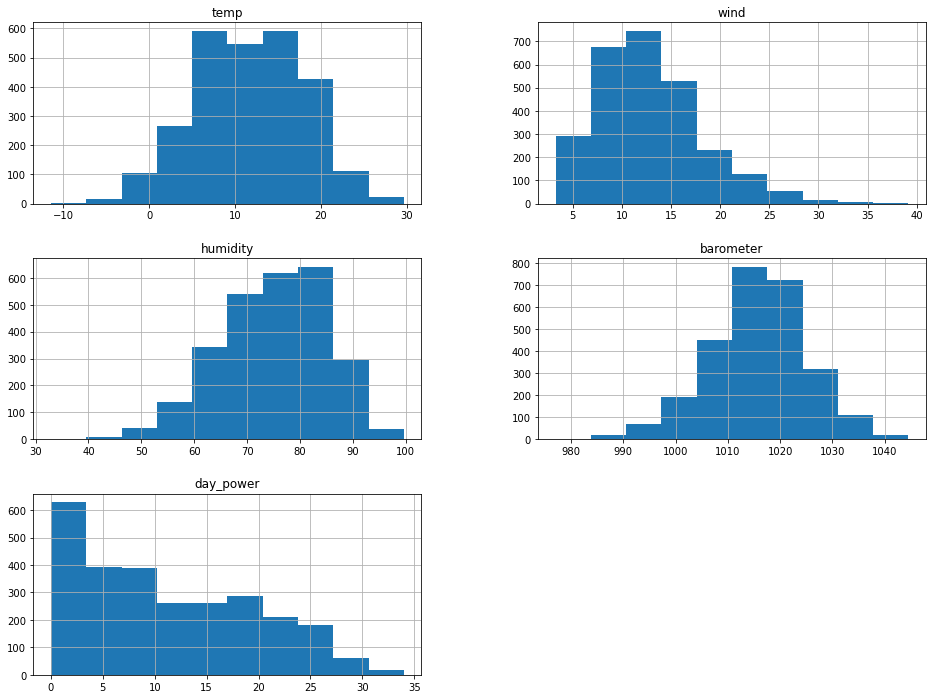

In [6]:
final_dataset.hist(figsize=(16,12))
plt.show()

In [7]:
df.corr()

,temp,wind,humidity,barometer,day_power
temp,1.000000,-0.116808,-0.447690,-0.029543,0.628767
wind,-0.116808,1.000000,-0.001582,-0.366384,-0.216053
humidity,-0.447690,-0.001582,1.000000,-0.145609,-0.742221
barometer,-0.029543,-0.366384,-0.145609,1.000000,0.178460
day_power,0.628767,-0.216053,-0.742221,0.178460,1.000000


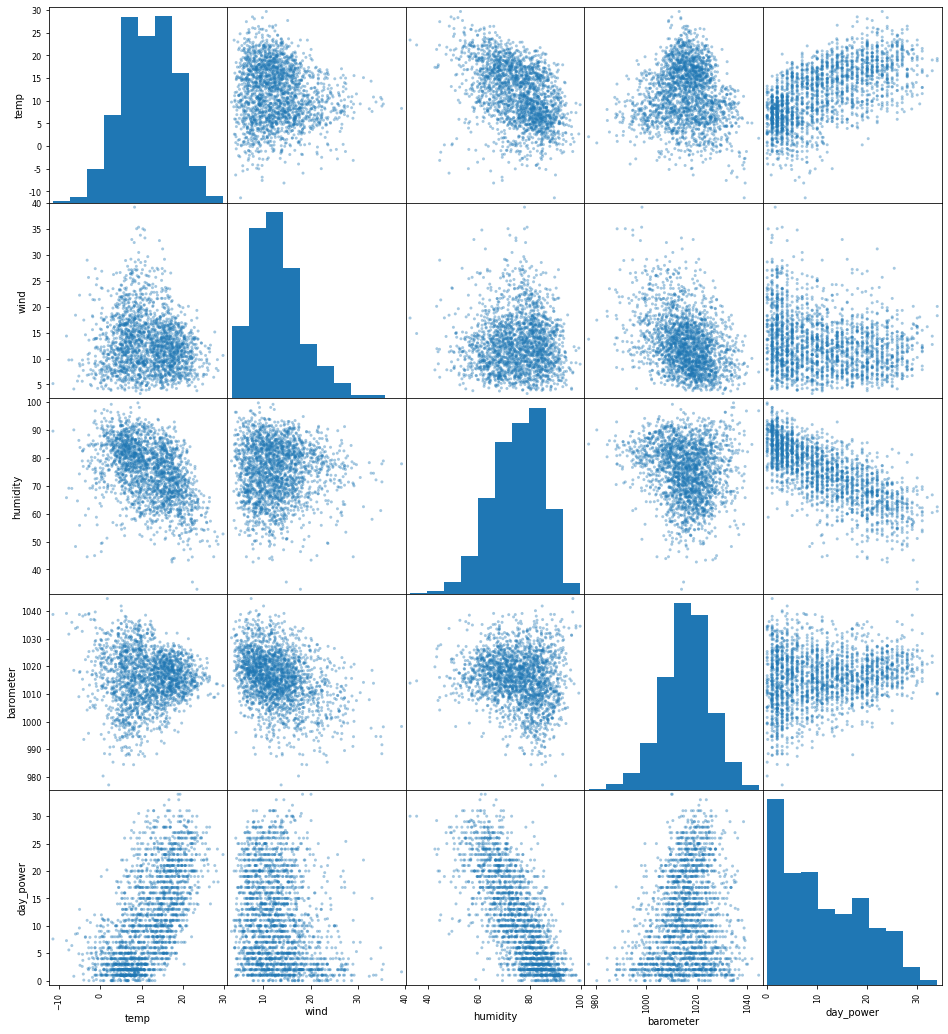

In [8]:
scatter_matrix(df, figsize=(16,18), alpha=0.4) 
plt.show()

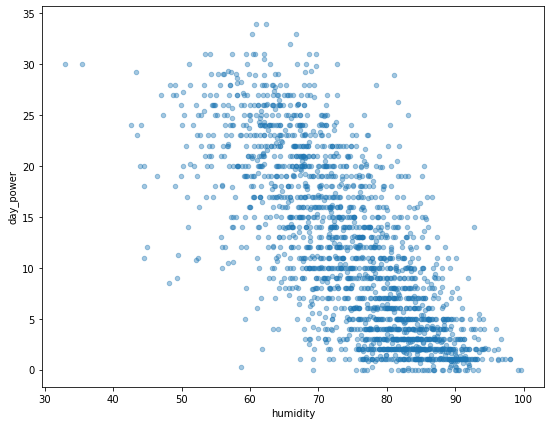

In [9]:
df.plot(kind='scatter', x= 'humidity',y='day_power', figsize=(9,7), alpha=0.4) 
plt.show()

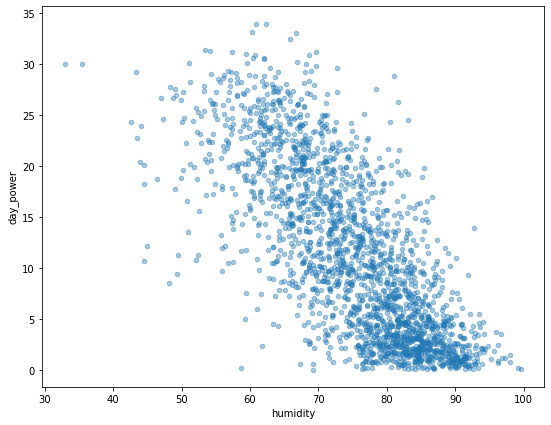

In [10]:
#To delete data anomalies
df.day_power = df.day_power.apply(lambda x: x+random.randint(0,50)/100 if x==0 else x)
for i in range(1,34):
    df.day_power = df.day_power.apply(lambda x: x+random.randint(-50,50)/100 if x==i else x)
df.plot(kind='scatter', x= 'humidity',y='day_power', figsize=(9,7), alpha=0.4) 
plt.show()

## Make a pipeline to preprocessing

In [11]:
#As we have data (which we want to predict), without barometer column
features = df.drop(['day_power', 'barometer'], axis=1) 
columns=features.columns 
labels = df['day_power'].copy() 
features.head() 

,temp,weather,wind,humidity
date,,,,
2016-04-13,9.953488,Passing clouds,7.790698,71.604651
2019-06-19,19.739130,Sunny,10.347826,78.543478
2018-05-15,18.777778,Passing clouds,11.400000,59.000000
2012-03-01,7.750000,Fog,5.791667,91.125000
2019-09-17,14.833333,Scattered clouds,11.395833,66.187500


In [12]:
num_attr = list(features.drop(['weather'],axis=1)) 
cat_attr = ['weather'] 

In [13]:
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import MinMaxScaler 


num_pipeline = Pipeline([ 
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler()) 
]) 

cat_pipeline = Pipeline([ 
    ('encoder', OneHotEncoder()) 
]) 

full_pipeline = ColumnTransformer([ 
    ('num_pipeline', num_pipeline, num_attr),
    ('cat_pipeline', cat_pipeline, cat_attr) 
])

In [14]:
prepared_features = full_pipeline.fit_transform(features)

## Linear Regression Model

In [15]:
lin_reg = LinearRegression() 
lin_reg.fit(prepared_features, labels) 
y_predicted = lin_reg.predict(prepared_features) 
scores = cross_val_score(lin_reg, prepared_features, labels, 
                         scoring='neg_mean_squared_error', cv=10) 
scores=np.sqrt(-scores) 
display(scores.mean()) 
scores.std() 

4.564225934776323

0.192045371885417

In [16]:
test = test_set.copy()
test_features = test.drop(['day_power', 'barometer'], axis=1) 
test_labels = test['day_power'].copy() 

In [17]:
prepared_test = full_pipeline.transform(test_features) 
test_predicted = lin_reg.predict(prepared_test)

In [18]:
scores = cross_val_score(lin_reg, prepared_test, test_labels, 
                         scoring='neg_mean_squared_error', cv=10) 
scores=np.sqrt(-scores) 
display(scores.mean()) 
scores.std() 

4.404753865242534

0.3131011507788302

## Comparing between Actual and Predicted

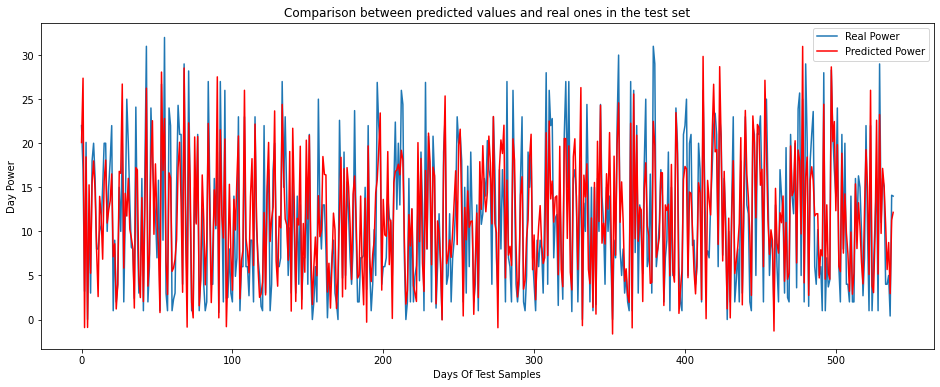

In [20]:
plt.figure(figsize=(16,6))
plt.plot(range(len(test_labels)), test_labels)
plt.plot(range(len(test_predicted)), test_predicted, 'r')
plt.title('Comparison between predicted values and real ones in the test set')
plt.ylabel('Day Power')
plt.xlabel('Days Of Test Samples')
plt.legend(['Real Power', 'Predicted Power'])
plt.show()

### Visualizing the difference between predicted and real values of day power for the test set

In [21]:
avg=[]
labels_avg = []
for i in range(len(test_labels)):
    avg.append(test_labels[i])
    if i % 30 == 0:
        labels_avg.append(np.array(avg).mean())
        avg.clear()
avg=[]
pred_avg = []
for i in range(len(test_predicted)):
    avg.append(test_predicted[i])
    if i % 30 == 0:
        pred_avg.append(np.array(avg).mean())
        avg.clear()

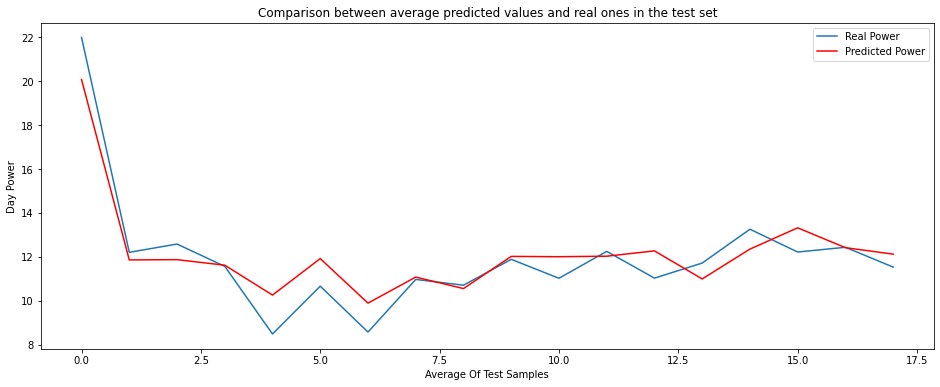

In [22]:
plt.figure(figsize=(16,6))
plt.plot(range(len(labels_avg)), labels_avg)
plt.plot(range(len(pred_avg)), pred_avg, 'r')
plt.title('Comparison between average predicted values and real ones in the test set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Test Samples')
plt.legend(['Real Power', 'Predicted Power'])
plt.show()

## RandomForest Model

In [23]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor() 
rf_reg.fit(prepared_features, labels) 
y_predicted = rf_reg.predict(prepared_features) 
scores = cross_val_score(rf_reg, prepared_features, labels, 
                         scoring='neg_mean_squared_error', cv=10) 
scores=np.sqrt(-scores) 
display(scores.mean()) 
scores.std() 

4.565290075312312

0.18535237750726577

In [24]:
test = test_set.copy()
test_features = test.drop(['day_power', 'barometer'], axis=1) 
test_labels = test['day_power'].copy() 

In [25]:
prepared_test = full_pipeline.transform(test_features) 
test_predicted = rf_reg.predict(prepared_test)

In [26]:
scores = cross_val_score(rf_reg, prepared_test, test_labels, 
                         scoring='neg_mean_squared_error', cv=10) 
scores=np.sqrt(-scores) 
display(scores.mean()) 
scores.std() 

4.5307681257610515

0.3924063394515163

In [27]:
avg=[]
labels_avg = []
for i in range(len(test_labels)):
    avg.append(test_labels[i])
    if i % 30 == 0:
        labels_avg.append(np.array(avg).mean())
        avg.clear()
avg=[]
pred_avg = []
for i in range(len(test_predicted)):
    avg.append(test_predicted[i])
    if i % 30 == 0:
        pred_avg.append(np.array(avg).mean())
        avg.clear()

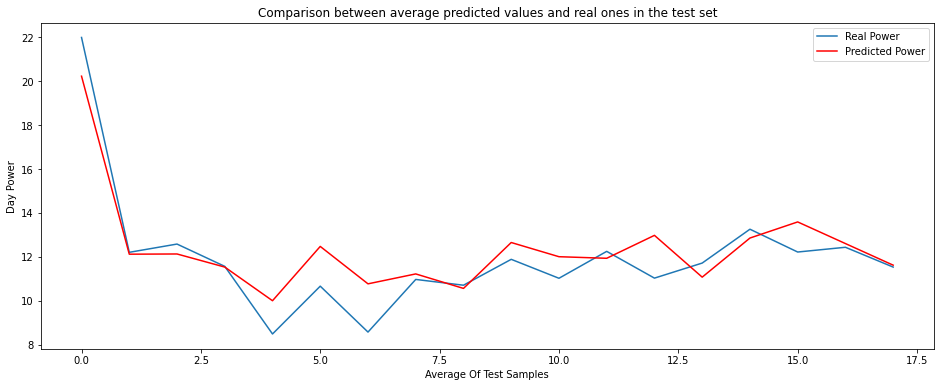

In [28]:
plt.figure(figsize=(16,6))
plt.plot(range(len(labels_avg)), labels_avg)
plt.plot(range(len(pred_avg)), pred_avg, 'r')
plt.title('Comparison between average predicted values and real ones in the test set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Test Samples')
plt.legend(['Real Power', 'Predicted Power'])
plt.show()